In [246]:
%matplotlib inline
from matplotlib import pyplot as plt
import xarray as xr
import numpy as np

from RAiDER.models import HRES

In [247]:
# load sample data
ds1 = xr.open_dataset('/u/aurora-r0/govorcin/01_OPERA/TROPO/interface/tropo/tests/data/test_data.nc')

## RAIDER calculation

In [243]:
hres_model = HRES()

# Extract temperature and specific humidity at the first time step
hres_model._t = ds1.t.isel(time=0).values
hres_model._q = ds1.q.isel(time=0).values

# Extract longitude and latitude values
longitude = ds1.longitude.values
latitude = ds1.latitude.values

# Use geopotential heights and log of surface pressure
# to get pressure, geopotential, and geopotential height
_, pres, hgt = hres_model._calculategeoh(
        ds1.z.isel(time=0, level=0).values,
        ds1.lnsp.isel(time=0, level=0).values
)
hres_model._p = pres

# Create latitude and longitude grid
hres_model._lons, hres_model._lats = np.meshgrid(longitude, latitude)

# Get altitudes
hres_model._get_heights(hres_model._lats, hgt.transpose(1, 2, 0))
h = hres_model._zs.copy()

# Re-structure arrays from (heights, lats, lons) to (lons, lats, heights)
hres_model._p = np.flip(hres_model._p.transpose(1, 2, 0), axis=2)
hres_model._t = np.flip(hres_model._t.transpose(1, 2, 0), axis=2)
hres_model._q = np.flip(hres_model._q.transpose(1, 2, 0), axis=2)
hres_model._zs = np.flip(h, axis=2)
hres_model._xs, hres_model._ys = hres_model._lons.copy(), hres_model._lats.copy()
 
# Perform RAiDER computations
hres_model._find_e() 
h = hres_model._zs.copy()
hres_model._uniform_in_z(_zlevels=None)
hres_model._checkForNans()

# Refractivity
hres_model._get_wet_refractivity()
hres_model._get_hydro_refractivity()
hres_model._adjust_grid(hres_model.get_latlon_bounds())

# Compute zenith delays at the weather model grid nodes
hres_model._getZTD()

# Xarray - comp
there is some difference in precision, notice diff comes python native function, array and xarray/dask compution with float32/64

## Functions

In [263]:
# Constants
R_v = 461.524
k1 = 0.776  # [K/Pa]
k2 = 0.233  # [K/Pa]
k3 = 3.75e3  # [K^2/Pa]
g0 = 9.80665
G1 = 9.80616
Rmax = 6378137
Rmin = 6356752
R_d = 287.06  # in our original code this was 287.053

# Needed RAIDER interpolator
# option would be to use c-code and its bindings itself
from RAiDER.interpolate import interpolate_along_axis
from RAiDER.interpolator import fillna3D
from RAiDER.models.model_levels import (A_137_HRES, B_137_HRES, LEVELS_137_HEIGHTS)

# Step 1 - calc surface pressure, geopotential heights
def get_surface_pressure(lnsp : xr.DataArray):
    isel = {}
    #Strip time and level dims 
    for i in ['time', 'level']:
        isel[i] = 0 if i in lnsp.dims else None

    lnsp = lnsp.isel(isel)
    lnsp = lnsp.expand_dims(level=range(138))
    #lnsp = lnsp.astype(np.float32)

    # Get expanded a and b HRES values
    A_expanded = np.atleast_1d(A_137_HRES)[:, np.newaxis, np.newaxis]
    B_expanded = np.atleast_1d(B_137_HRES)[:, np.newaxis, np.newaxis]

    return  A_expanded + B_expanded * np.exp(lnsp)

# NOTE geopotential is slower than expected ~400ms, try to replace diff
# array substraction array[1:]-array[:-1]
def get_geopotential(t : xr.DataArray,
                     q : xr.DataArray,
                     z : xr.DataArray,
                     lnsp : xr.DataArray):
    # Get surface pressure
    Phd = get_surface_pressure(lnsp)

    # Get log and alpha at half levels
    Phd[0] = 1e-10
    dlogP = np.log(Phd).diff(dim="level", label='lower')
    dlogP[0] = np.log(Phd.isel(level=1) / 0.1)

    alpha = 1 - (Phd[:-1] / (Phd.diff(dim="level", label='lower'))) * dlogP
    alpha[0] *= np.float32(np.log(2))

    # Reverse
    dlogP = dlogP.isel(level=slice(None, None, -1))
    alpha = alpha.isel(level=slice(None, None, -1))
    dlogP = dlogP.assign_coords(level=range(1,138))
    alpha = alpha.assign_coords(level=range(1,138))

    # compute moist temperature amd reverse
    moist = t * (1 + 0.609133 * q)
    TRd = moist.isel(level=slice(None, None, -1)) * R_d
    TRd = TRd.assign_coords(level=range(1,138))
    z1 = TRd * alpha + z.isel(level=0).expand_dims(level=range(1, 138))
    z2 = TRd * dlogP

    # Get Geopotential, in reverse
    return z1 + z2.cumsum('level').shift(level=1, fill_value=0)

# Step 2 - Geopotential heights to ellipsoidal heights
# Geoheight to ellipsoidal heights
def get_Re(lats: np.array) -> np.array:
    """
    Returns earth radius as a function of latitude for WGS84.

    Args: lats
        ndarray of geodetic latitudes in degrees

    Returns:
        ndarray of earth radius at each latitude

    Example:
    >>> import numpy as np
    >>> from RAiDER.utilFcns import get_Re
    >>> output = get_Re(np.array([0, 30, 45, 60, 90]))
    >>> output
     array([6378137., 6372770.5219805, 6367417.56705189, 6362078.07851428, 6356752.])
    >>> assert output[0] == 6378137 # (Rmax)
    >>> assert output[-1] == 6356752 # (Rmin)
    """
    return np.sqrt(1 / (((np.cos(np.radians(lats)) ** 2) / Rmax**2) + ((np.sin(np.radians(lats)) ** 2) / Rmin**2)))

def _get_g_ll(lats: np.array) ->  np.array:
    """Compute the variation in gravity constant with latitude."""
    return G1 * (1 - 0.002637 * np.cos(np.radians(2 * lats)) + 0.0000059 * (np.cos(np.radians(2 * lats))) ** 2)

def ght2hgt(ght:xr.DataArray):
    # Ellipsoidal height
    g_ll = _get_g_ll(ght.latitude)  # gravity function of latitude
    Re = get_Re(ght.latitude)  # Earth radius function of latitude
    return (ght * Re) / (g_ll / g0 * Re - ght)

# Step 3 Get water pressure
# Partial pressure
def get_svp_xr(t : xr.DataArray):
    t1 = 273.15  # O Celsius
    t2 = 250.15  # -23 Celsius

    tref = t - t1
    wgt = (t - t2) / (t1 - t2)

    tref = t - t1
    wgt = (t - t2) / (t1 - t2)
    svpw = 6.1121 * np.exp((17.502 * tref) / (240.97 + tref))
    svpi = 6.1121 * np.exp((22.587 * tref) / (273.86 + tref))

    svp = svpi + (svpw - svpi) * wgt**2

    svp = svpi + (svpw - svpi) * wgt**2
    ix_bound1 = t > t1
    svp = svp.where(~ix_bound1, svpw)

    ix_bound2 = t < t2
    svp = svp.where(~ix_bound2, svpi)

    return svp * 100

def get_e_from_q(t : xr.DataArray,
                 q : xr.DataArray,
                 p : xr.DataArray):
    # Get standard vapor pressure
    svp = get_svp_xr(t)

    w = q / (1 - q)
    return w * R_v * (p - svp) / R_d

# Step 4 Interpolate to unifrom heights
def uniform_heights(ds : xr.DataArray, hgt: xr.DataArray, 
                    new_heights : list, fill_value:float=0):
    # new heights
    ds= ds.copy()
    new_shape = (ds.sizes['latitude'], ds.sizes['longitude'], 1) 
    new_zs = np.tile(new_heights, new_shape)

    # Interpolate
    ds = ds.transpose('time', 'latitude', 'longitude', 'level')
    hgt = hgt.transpose('time', 'latitude', 'longitude', 'level')
    isel_slice = dict(time=0)
    interp = interpolate_along_axis(hgt.isel(isel_slice),
                                    ds.isel(isel_slice)[:,:,::-1],
                                    new_zs,  axis=2, 
                                    fill_value=np.nan)
    # fill nans
    inter_filled = fillna3D(interp, fill_value=fill_value)

    return xr.DataArray(inter_filled.transpose(2,0,1),
                        dims=['height', 'latitude', 'longitude'],
                        coords={'height':new_heights,
                              'latitude':ds.latitude,
                              'longitude':ds.longitude})

# Step 5 Get ZTD 
def cumulative_trapz_vectorized(data):
    """
    Perform cumulative trapezoidal integration efficiently using vectorized operations.

    Parameters:
        data (np.ndarray): Data values to integrate, shape (height, lat, lon).
        height (np.ndarray): Height levels, shape (height,).

    Returns:
        np.ndarray: Integrated values at each height level.
    """
    # Get output datarray
    out_xr = xr.zeros_like(data)
    # Compute differential heights (shape: (height-1,))
    dh = np.diff(data.height)

    # Ensure broadcasting: Reshape `dh` to (height-1, 1, 1) to match (height, lat, lon)
    dh = dh[:, np.newaxis, np.newaxis]

    # Compute trapezoidal integration elements: (height-1, lat, lon)
    trapz_values = 0.5 * (data[:-1].data + data[1:].data) * dh

    # Compute cumulative integral from top to bottom (reverse order)
    out_xr[:-1] = 1e-6 * np.cumsum(trapz_values[::-1], axis=0)[::-1]

    return out_xr

def get_ztd(wet_ref:xr.DataArray, hydro_ref:xr.DataArray):
    hydro = cumulative_trapz_vectorized(hydro_ref)
    wet = cumulative_trapz_vectorized(wet_ref)
    return xr.Dataset(data_vars={'hydro': hydro.astype(np.float32),
                                 'wet': wet.astype(np.float32),
                                 'hydro_ref':hydro_ref.astype(np.float32),
                                 'wet_ref':wet_ref.astype(np.float32)})


In [244]:
# Workflow
def ztd_xr(da : xr.Dataset):
    # Get surface pressure and geopotential
    p = get_surface_pressure(da.lnsp)[:-1]
    da['p'] = p.assign_coords(level=range(1,138)).expand_dims('time')

    # Geoheights
    ght = get_geopotential(da.t, da.q,
                           da.z, da.lnsp).astype(np.float32) / g0
    # Ellipsoidal height
    hgt = ght2hgt(ght)

    # Partial pressure
    da['e'] = get_e_from_q(da.t, da.q, da.p)
    # drop unenssessary
    da = da.drop_vars(['z', 'lnsp', 'q'])

    # Uniform heights
    t_interp = uniform_heights(da.t, hgt, np.flipud(LEVELS_137_HEIGHTS), 1e16)
    e_interp = uniform_heights(da.e, hgt, np.flipud(LEVELS_137_HEIGHTS), 0)
    p_interp= uniform_heights(da.p, hgt, np.flipud(LEVELS_137_HEIGHTS), 0)

    # Get refractivity
    wet_refractivity = k2 * e_interp / t_interp + k3 * e_interp / t_interp**2
    hydrostatic_refractivity = k1 * p_interp / t_interp

    # Get ztd
    ztd = get_ztd(wet_refractivity, hydrostatic_refractivity) 
    return ztd


In [276]:
%%time
out1 = ztd_xr(ds1)

CPU times: user 7.13 s, sys: 1.84 s, total: 8.97 s
Wall time: 8.5 s


In [250]:
%%time
from opera_tropo.core import calculate_ztd
out2 = calculate_ztd(ds1)

CPU times: user 10.4 s, sys: 5.71 s, total: 16.1 s
Wall time: 15.6 s


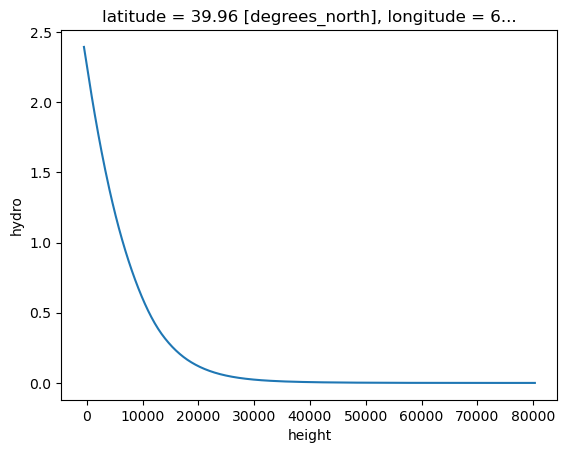

In [282]:
out1.hydro[:,0,0].plot()

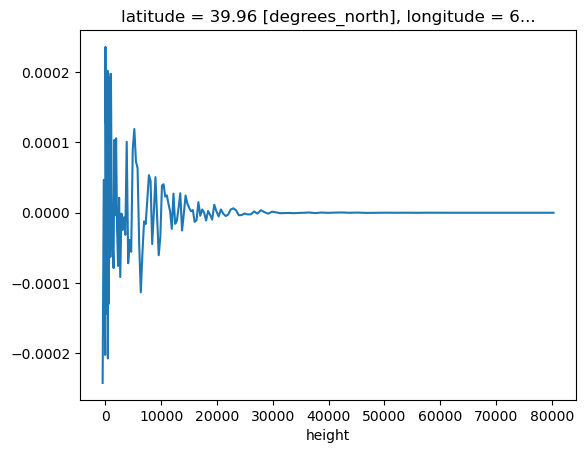

In [277]:
# NOTe difference could be also due to mantissa rounding
(out1.hydro[:,0,0] - out2.hydrostatic_delay[0,:,0,0]).plot()

In [271]:
from opera_tropo.utils import rounding_mantissa_blocks

In [278]:
out1 = rounding_mantissa_blocks(out1, 12)

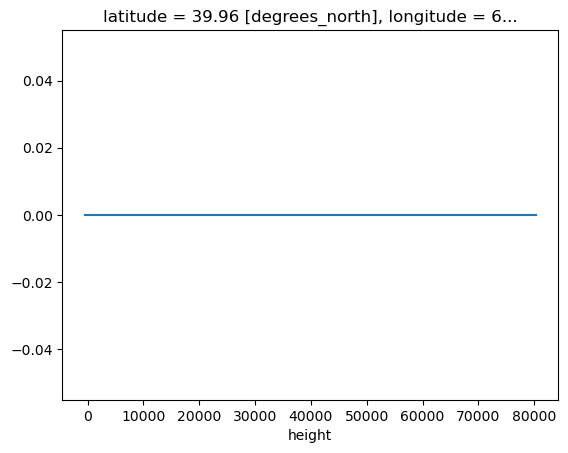

In [279]:
# NOTe difference could be also due to mantissa rounding
(out1.hydro[:,0,0] - out2.hydrostatic_delay[0,:,0,0]).plot()

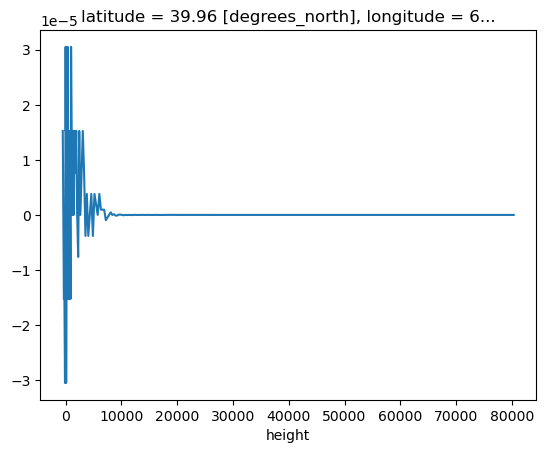

In [280]:
# wet delay has different bit rounding of 10
(out1.wet[:,0,0] - out2.wet_delay[0,:,0,0]).plot()

# Reverse integration

In [102]:
def retrieve_original_data(integrated_data, data_height):
    """
    Reverse the cumulative trapezoidal integration to retrieve the original data.

    Parameters:
        integrated_data (np.ndarray): Integrated data values, shape (height, lat, lon).
        data_height (np.ndarray): Height levels, shape (height,).

    Returns:
        np.ndarray: Reconstructed original data values at each height level.
    """
    # Compute the differential heights (shape: (height-1,))
    dh = np.diff(data_height)

    # Ensure broadcasting of `dh` for the dimensions of `integrated_data`
    dh = dh[:, np.newaxis, np.newaxis]

    # Initialize an empty array for the reconstructed data
    reconstructed_data = np.zeros_like(integrated_data, dtype=np.float32)

    # Compute the differences between consecutive integrated values
    # (integrated_data[i] - integrated_data[i-1]) gives the trapezoidal area
    reconstructed_data[1:] = 1e6 * np.diff(integrated_data[::-1], axis=0) / dh[::-1]

    return reconstructed_data[::-1]

In [27]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt

In [3]:
ds = xr.open_dataset('/u/aurora-r0/govorcin/01_OPERA/TROPO/interface/tropo/tests/data/output_data.nc')
ds

<xarray.Dataset> Size: 71MB
Dimensions:                   (time: 1, latitude: 142, longitude: 143,
                               height: 145)
Coordinates:
  * time                      (time) datetime64[ns] 8B 2024-02-15T12:00:00
  * latitude                  (latitude) float32 568B 34.97 34.9 ... 25.13 25.06
  * longitude                 (longitude) float32 572B 80.02 80.09 ... 90.0
  * height                    (height) float64 1kB -500.0 -300.0 ... 8.03e+04
Data variables:
    hydrostatic_refractivity  (time, latitude, longitude, height) float32 12MB ...
    wet_refractivity          (time, latitude, longitude, height) float32 12MB ...
    hydrostatic_ztd           (time, latitude, longitude, height) float64 24MB ...
    wet_ztd                   (time, latitude, longitude, height) float64 24MB ...

In [103]:
ds = ds.transpose('time','height','latitude','longitude')
reconstructed_data = retrieve_original_data(ds.hydrostatic_ztd.isel(time=0), ds.height)

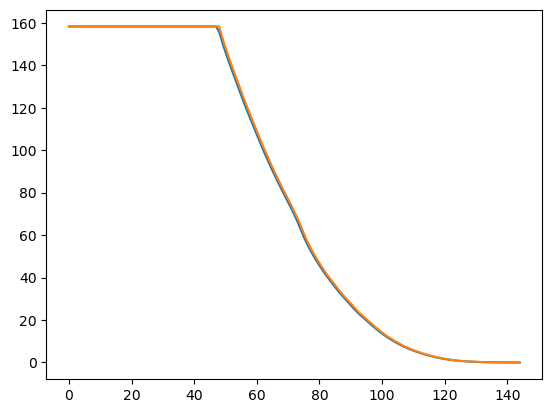

In [104]:
plt.plot(reconstructed_data[:,0,0].astype(np.float32))
plt.plot(ds.hydrostatic_refractivity[0,:,0,0])

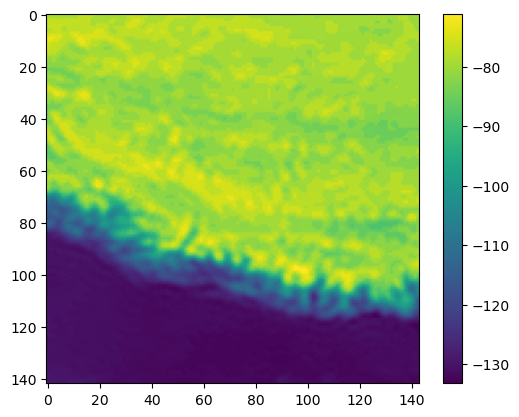

In [108]:
plt.imshow(np.sum(reconstructed_data - hydro_ref, axis=0))
plt.colorbar()

In [105]:
hydro_ref = ds.hydrostatic_refractivity.isel(time=0).values.copy()

-79.13243

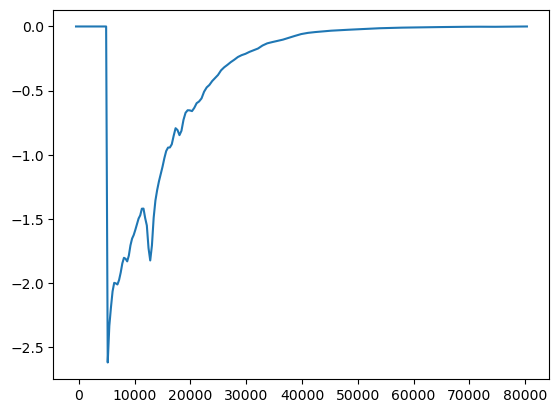

In [115]:
plt.plot(ds.height, (reconstructed_data[:,0,0].astype(np.float32) - hydro_ref[:,0,0])) # difference
np.sum(reconstructed_data[:,0,0] - hydro_ref[:,0,0])

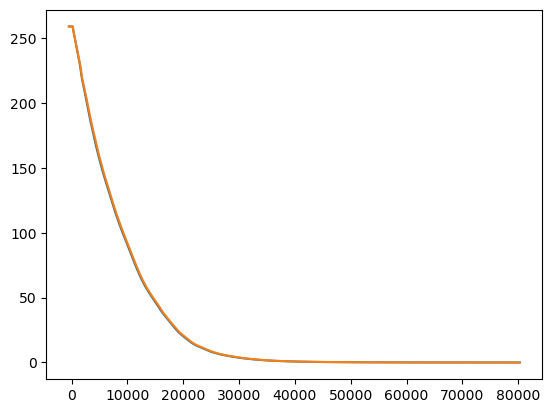

In [113]:
plt.plot(ds.height, reconstructed_data[:,140, 0].astype(np.float32))
plt.plot(ds.height, ds.hydrostatic_refractivity[0,:,140,0])

-129.50798

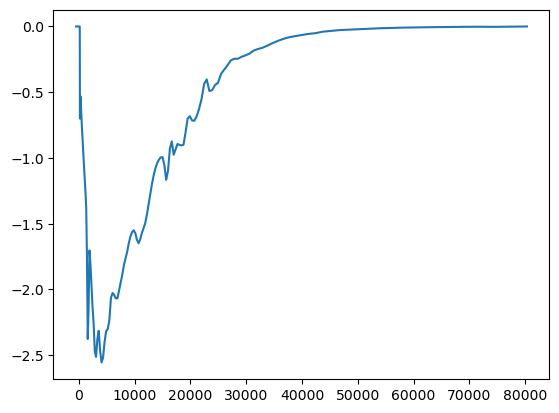

In [112]:
plt.plot(ds.height, (reconstructed_data[:,140,0].astype(np.float32) - hydro_ref[:,140,0])) # difference
np.sum(reconstructed_data[:,140,0] - hydro_ref[:,140,0])